In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import matplotlib.rcsetup
import seaborn as sns
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline

In [5]:
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [6]:
df = pd.read_csv('train.csv', index_col ='Id')
test_df = pd.read_csv('test.csv', index_col='Id')

### First glance at the data

Text(0.5, 1.0, 'Distribution of house prices')

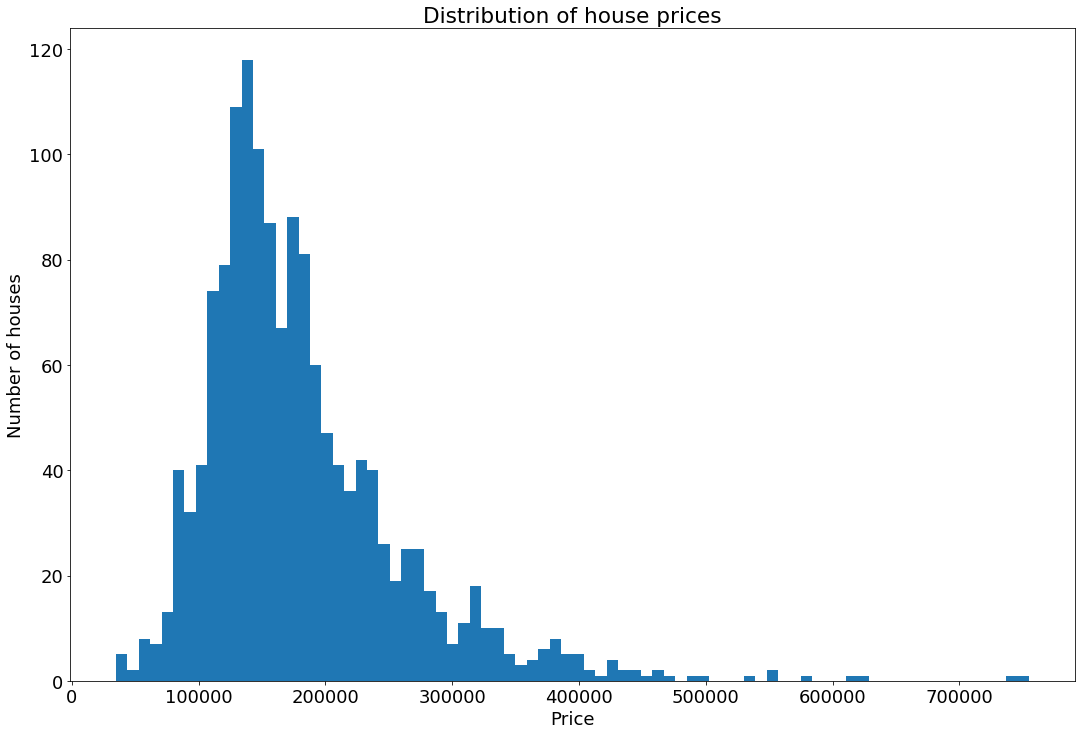

In [7]:
plt.figure(figsize=(18, 12))
plt.hist(df['SalePrice'], bins=80)
plt.xlabel('Price')
plt.ylabel('Number of houses')
plt.title('Distribution of house prices')

Text(0.5, 1.0, 'Distribution of house prices, logarithmic scale')

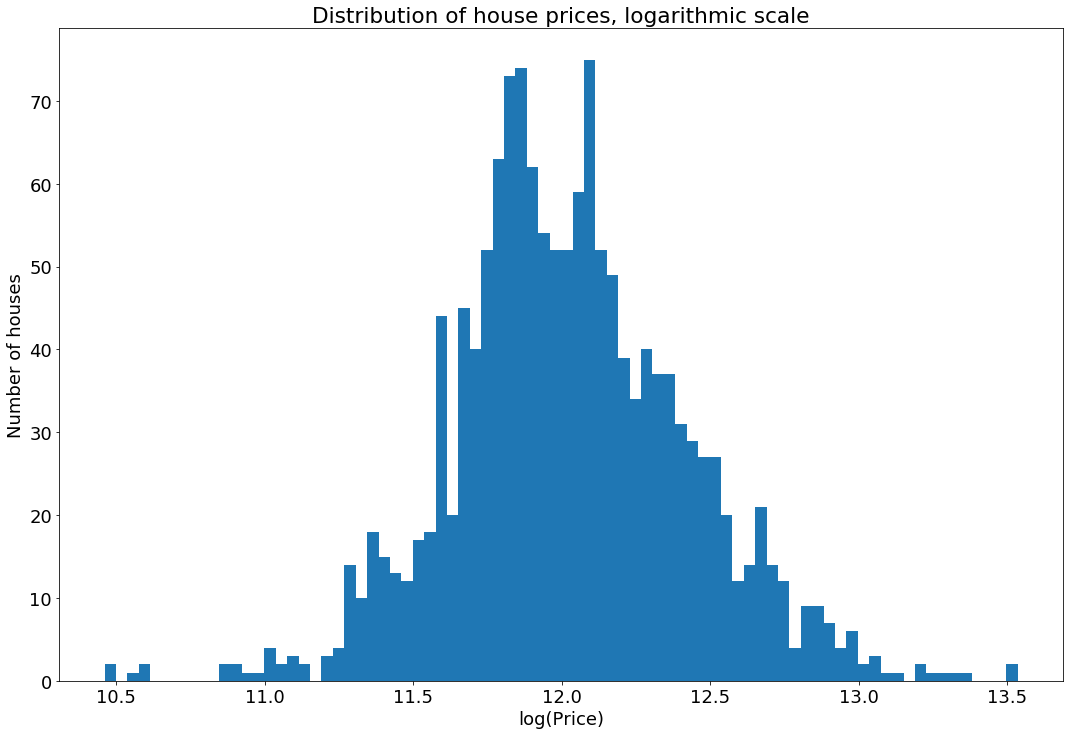

In [9]:
plt.figure(figsize=(18, 12))
plt.hist(np.log(df['SalePrice']), bins=80)
plt.xlabel('log(Price)')
plt.ylabel('Number of houses')
plt.title('Distribution of house prices, logarithmic scale')

Looks like a gaussian distribution!

In [10]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Naive (first-iteration) model

Below is the description of the columns

In [25]:
X = df[['BedroomAbvGr', 'FullBath', 'LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageType', 'PoolQC']]
test_X = test_df[['BedroomAbvGr', 'FullBath', 'LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'GarageType', 'PoolQC']]
y_max = df['SalePrice'].max()
y = np.log(df['SalePrice'])

In [26]:
# We make 'GarageType' a binary feature, 1 if there's a garage, 0 otherwise (same for 'PoolQC')

X['GarageType'].loc[X['GarageType'].notnull()] = 1
X['PoolQC'].loc[X['PoolQC'].notnull()] = 1
X.fillna(value=0, inplace=True)

# same for test_X
test_X['GarageType'].loc[test_X['GarageType'].notnull()] = 1
test_X['PoolQC'].loc[test_X['PoolQC'].notnull()] = 1
test_X.fillna(value=0, inplace=True)

C:\Users\Temirlan\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Temirlan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Temirlan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [125]:
# Ridge on the logarithms of prices
from sklearn.linear_model import Ridge
ridge = Ridge()
params = {'alpha' : [0.1, 0.5, 1.0, 1.5, 2.0, 5.0]}

grid_ridge = GridSearchCV(estimator=ridge, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X, y)
best_estimator = grid_ridge.best_estimator_
print(grid_ridge.best_params_)
print('best score : %.6f' % (-grid_rf.best_score_))

# our first results (Ridge regression)
y_pred = np.exp(best_estimator.predict(test_X))
output = pd.DataFrame(index=test_df.index, data=y_pred, columns=['SalePrice'])
output.to_csv('predictions.csv', header=True)

{'alpha': 0.1}
best score : 0.001220


On test data Kaggle returns RLMSE = 0.18812

In [127]:
# Decision Tree Regressor
dt = DecisionTreeRegressor()
params = {'criterion' : ['mse'],
          'max_depth' : np.arange(2, 8),
          'min_samples_split' : [2, 3],
          'min_samples_leaf' : [1, 2, 3]}

grid_dt = GridSearchCV(estimator=dt, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_dt.fit(X=X, y=y)
best_estimator = grid_dt.best_estimator_
print(grid_dt.best_params_)
print('best score : %.6f' % (-grid_dt.best_score_))

y_pred = np.exp(best_estimator.predict(test_X))
output = pd.DataFrame(index=test_df.index, data=y_pred, columns=['SalePrice'])
output.to_csv('predictions.csv', header=True)

{'criterion': 'mse', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
best score : 0.042362


On test data Kaggle returns RLMSE = 0.0.20369

In [128]:
# Random Forest Regressor
rf = RandomForestRegressor()
params = {'criterion' : ['mse'],
          'n_estimators' : [50, 100, 200],
          'max_depth' : np.arange(2, 8),
          'min_samples_split' : [2, 3]}

grid_rf = GridSearchCV(estimator=rf, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_rf.fit(X, y)
best_estimator = grid_rf.best_estimator_
print(grid_rf.best_params_)
print('best score : %.6f' % (-grid_rf.best_score_))

y_pred = np.exp(best_estimator.predict(test_X))
output = pd.DataFrame(index=test_df.index, data=y_pred, columns=['SalePrice'])
output.to_csv('predictions.csv', header=True)

{'criterion': 'mse', 'max_depth': 7, 'min_samples_split': 3, 'n_estimators': 100}
best score : 0.031884


On test data Kaggle returns RLMSE = 0.17697

In [130]:
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor

dt = DecisionTreeRegressor()
params = {'base_estimator__criterion' : ['mse'],
          'base_estimator__max_depth' : [1,2],
          'n_estimators' : [50, 100, 200],
          'learning_rate' : [0.5, 1.0, 2.0]
}

ab = AdaBoostRegressor(base_estimator=dt)
grid_ab = GridSearchCV(estimator=ab, param_grid=params, cv=5, scoring='neg_mean_squared_error')

grid_ab.fit(X, y)
best_estimator = grid_ab.best_estimator_
print(grid_ab.best_params_)
print('best score : %.6f' % (-grid_ab.best_score_))

y_pred = np.exp(best_estimator.predict(test_X))
output = pd.DataFrame(index=test_df.index, data=y_pred, columns=['SalePrice'])
output.to_csv('predictions.csv', header=True)

{'base_estimator__criterion': 'mse', 'base_estimator__max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 100}
best score : 0.051443


On test data Kaggle returns RLMSE = 0.22913

In [132]:
# Gradient Boosting (sklearn)
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()
params = {'max_depth' : [1, 2, 3],
          'n_estimators' : [100, 200],
          'learning_rate' : [0.05, 0.1, 0.2]
}

grid_gb = GridSearchCV(estimator=gb, param_grid=params, cv=5, scoring='neg_mean_squared_error')

grid_gb.fit(X, y)
best_estimator = grid_gb.best_estimator_
print(grid_gb.best_params_)
print('best score : %.6f' % (-grid_gb.best_score_))

y_pred = np.exp(best_estimator.predict(test_X))
output = pd.DataFrame(index=test_df.index, data=y_pred, columns=['SalePrice'])
output.to_csv('predictions.csv', header=True)

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
best score : 0.027871


On test data Kaggle returns RLMSE = 0.17225. This is the best result so far!